# References:

* manual:  
    * [data-download](https://gisgeography.com/how-to-download-sentinel-satellite-data/)  
    * [ndvi-calculation-qgis](https://gisgeography.com/how-to-ndvi-maps-arcgis/)  
    * [image-classification-qgis](https://gisgeography.com/image-classification-techniques-remote-sensing/)  
    
    
* programmatically:  
    * [data-download](http://sentinelsat.readthedocs.io/en/stable/)  
    * [ndvi-calculation](http://neondataskills.org/HDF5/calc-ndvi-python/)  
    * [CCCI](https://www.researchgate.net/publication/259360047_Use_of_the_Canopy_Chlorophyl_Content_Index_CCCI_for_Remote_Estimation_of_Wheat_Nitrogen_Content_in_Rainfed_Environments), [EVI](https://en.wikipedia.org/wiki/Enhanced_vegetation_index), [SAVI](https://en.wikipedia.org/wiki/Soil-adjusted_vegetation_index) 
    * simple solution based on color band wavelength thresholding
    * machine learning based solution:
        * deep learning for computer vision: convolutional neural networks
        * [Kaggle-solution-satellite-images-classification](http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/)
    
    
    
# Solution:
    * backend: Python Flask + ML lib: scikit-learn/TensorFlow 
    * frontend: ReactJS?

# Data analysis starter code
## Data collection using ESA sentinel data products
References:
* [sentinelsat github](https://github.com/sentinelsat/sentinelsat/blob/127619f6baede1b5cc852b208d4e57e9f4d518ee/README.rst)

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
from geojson import Polygon
from datetime import date
import json
import folium

with open('sentinel_user_login.json', 'r') as fp:
    LOGIN_INFO = json.load(fp)
USER_NAME, PASSWORD = list(LOGIN_INFO.values())
# USER_NAME, PASSWORD = '<YourUserName>', '<YourPassword>'

# define a map polygon
coordinates = [[
    (18.025318309126252, 48.25365988314252),
    (17.945005267006067, 48.18825958525136),
    (18.043165651819628, 48.18825958525136),
    (18.025318309126252, 48.25365988314252),
    (18.025318309126252, 48.25365988314252)
]]
geojson = Polygon(coordinates=coordinates)

# connect to the API
api = SentinelAPI(USER_NAME, PASSWORD, 'https://scihub.copernicus.eu/dhus')

# search by polygon, time, and Hub query keywords
footprint = geojson_to_wkt(geojson)
dates = (date(2017, 6, 10), date(2017, 8, 24))
dates = (date(2018, 4, 1), date(2018, 4, 11))

# June to July maps
products = api.query(footprint,
                     date=dates,
                     platformname='Sentinel-2',
#                      producttype='S2MSI1C',
                     producttype='S2MSI2A',
                     area_relation='Intersects',  # area of interest is inside footprint
#                      area_relation='Contains',  # area of interest is inside footprint
#                      area_relation='IsWithin',  # area of interest is inside footprint
                     cloudcoverpercentage=(0, 40))

product_id = list(products.keys())[0]  # June

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
geo_df = api.to_geodataframe(products).loc[[product_id]][['geometry']]

def add_choropleth(mapobj, gdf, fill_color='Blue', fill_opacity=0.6,
                   line_opacity=0.2, num_classes=5):
    # Convert the GeoDataFrame to WGS84 coordinate reference system
    gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
    
    # Call Folium choropleth function, specifying the geometry as a the WGS84 dataframe converted to GeoJSON,
    # the data as the GeoDataFrame, the columns as the user-specified id field and and value field.
    # key_on field refers to the id field within the GeoJSON string
    mapobj.choropleth(
        geo_data=gdf_wgs84.to_json(),
        fill_color=fill_color,
        fill_opacity=fill_opacity,
        line_opacity=line_opacity,  
    )
    return mapobj

slovakia_map = folium.Map(np.mean(coordinates[0], 0).tolist()[::-1], zoom_start=8)
slovakia_map = add_choropleth(slovakia_map, geo_df)
slovakia_map

In [139]:
# download all results from the search
# api.download_all(products)
api.download(id=product_id, directory_path='../data')

Downloading: 100%|██████████| 1.20G/1.20G [04:12<00:00, 4.76MB/s]
MD5 checksumming: 100%|██████████| 1.20G/1.20G [00:02<00:00, 556MB/s]


{'id': '2e938509-84f3-4ae1-b2c4-0da5680c9588',
 'title': 'S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858',
 'size': 1203884722,
 'md5': '448BF75624F75C34FB668220E0F0E75B',
 'date': datetime.datetime(2018, 4, 8, 9, 50, 29, 27000),
 'footprint': 'POLYGON((17.718815262801492 48.720927698149374,19.208284435787206 48.676094448248996,19.1282606560594 47.69085106573984,17.667009418148023 47.73416799677996,17.718815262801492 48.720927698149374))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('2e938509-84f3-4ae1-b2c4-0da5680c9588')/$value",
 'path': '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.zip',
 'downloaded_bytes': 1203884722}

In [140]:
ll -h ../data/

total 1,5G
drwxr-xr-x 2 adrian 4,0K 14 apr 23:30 S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114_PROCESSED/
drwxr-xr-x 3 adrian 4,0K 11 apr 17:32 S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.SAFE/
-rw-r--r-- 1 adrian 313M 11 apr 16:43 S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.zip
-rw-r--r-- 1 adrian 1,2G 15 apr 00:14 S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.zip


## Data input types

In [4]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

def extract_table(wiki_page, header_row=0):
    soup = BeautifulSoup(requests.get(wiki_page).text, "html5lib")
    table = soup.find("table")
    rows = table.find_all("tr")

    header = [re.sub(r'(\[\d\])', '', x.text) for x in rows[header_row].find_all('th')]
    table = [[x.text for x in row.find_all('td')] for row in rows[header_row+1:]]
    return pd.DataFrame(table, columns=header)

In [5]:
page = 'https://gisgeography.com/how-to-download-sentinel-satellite-data'
wavelength_bands = extract_table(page, header_row=0)
wavelength_bands

Band Resolution Central Wavelength                       Description
0    B1       60 m             443 nm  Ultra blue (Coastal and Aerosol)
1    B2       10 m             490 nm                              Blue
2    B3       10 m             560 nm                             Green
3    B4       10 m             665 nm                               Red
4    B5       20 m             705 nm  Visible and Near Infrared (VNIR)
5    B6       20 m             740 nm  Visible and Near Infrared (VNIR)
6    B7       20 m             783 nm  Visible and Near Infrared (VNIR)
7    B8       10 m             842 nm  Visible and Near Infrared (VNIR)
8   B8a       20 m             865 nm  Visible and Near Infrared (VNIR)
9    B9       60 m             940 nm        Short Wave Infrared (SWIR)
10  B10       60 m            1375 nm        Short Wave Infrared (SWIR)
11  B11       20 m            1610 nm        Short Wave Infrared (SWIR)
12  B12       20 m            2190 nm        Short Wave Infrared (SWIR)

## Data input

In [141]:
from zipfile import ZipFile
filename = '../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.zip'
filename = '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.zip'
zip_file = ZipFile(filename)

_is_wave_band_img = lambda x: 'B' in x.filename and 'IMG_DATA' in x.filename
band_files = [x for x in zip_file.infolist() if _is_wave_band_img(x)]
zip_file.extractall(members=band_files, path='../data/')

In [ ]:
ll -h ../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.SAFE/GRANULE/L1C_T33PZK_A001935_20170720T092114/IMG_DATA/

In [146]:
ll -h ../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/

total 382M
-rw-r--r-- 1 adrian 946K 15 apr 00:18 T33UYP_20180408T095029_AOT_20m.jp2
-rw-r--r-- 1 adrian  33M 15 apr 00:18 T33UYP_20180408T095029_B02_20m.jp2
-rw-r--r-- 1 adrian  33M 15 apr 00:18 T33UYP_20180408T095029_B03_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B04_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B05_20m.jp2
-rw-r--r-- 1 adrian  35M 15 apr 00:18 T33UYP_20180408T095029_B06_20m.jp2
-rw-r--r-- 1 adrian  36M 15 apr 00:18 T33UYP_20180408T095029_B07_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B11_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B12_20m.jp2
-rw-r--r-- 1 adrian  36M 15 apr 00:18 T33UYP_20180408T095029_B8A_20m.jp2
-rw-r--r-- 1 adrian 4,9M 15 apr 00:18 T33UYP_20180408T095029_SCL_20m.jp2
-rw-r--r-- 1 adrian  49M 15 apr 00:18 T33UYP_20180408T095029_TCI_20m.jp2
-rw-r--r-- 1 adrian  22M 15 apr 00:18 T33UYP_20180408T095029_WVP_20m.jp2


# Convert images from .jp2 to .tiff format
* [gdal on Anaconda](https://anaconda.org/conda-forge/gdal)

# TODO:
* create own script for processing using gdal_merge.py with suitable arguments and/or similarly gdal_translate.py
* references:
    * [introduction to satellite imaging](https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971)
    * [stack exchange with gdal commands](https://gis.stackexchange.com/questions/257836/raw-sentinel-2-jp2-to-rgb-geotiff)
    * [reflectance values range](https://gis.stackexchange.com/questions/233874/what-is-the-range-of-values-of-sentinel-2-level-2a-images/234044)

# Run script

In [91]:
import os
from glob import glob
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline

files = glob('../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.SAFE/GRANULE/L1C_T33PZK_A001935_20170720T092114/IMG_DATA/*')
files = glob('../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/*')
files = sorted(files)
file_dict = dict(zip(['10m', '20m', '60m'], [sorted(glob(os.path.join(x, '*'))) for x in files]))

In [100]:
import subprocess
import numpy as np

def convert_to_geotiff(input_path, output_path, ot):
    cmd = "gdal_translate -ot {ot} -of GTiff -co TILED=YES {input} {output}"
    cmd = cmd.format(ot=ot, input=input_path, output=output_path)
    return cmd.split(" ")

def get_commands(vrt_file, tif_file, file_list, set_resolution=False, ot='Byte'):
    # Merge bands
    # merge_cmd = "gdalbuildvrt -separate {0} {1}".format(out_vrt_file, " ".join(file_list))
    merge_cmd_list = "gdalbuildvrt -separate".split(" ")
    resolution_cmd_list = "-resolution user -tr 20 20".split(" ")
    if set_resolution: merge_cmd_list += resolution_cmd_list
    vrt_cmd = merge_cmd_list + [vrt_file] + file_list
    # Convert to uncompressed GeoTiff
    # trsl_cmd = "gdal_translate -ot Byte -of GTiff -co TILED=YES {0} {1}".format(out_vrt_file, out_tif_file)
    trsl_cmd_list = convert_to_geotiff(vrt_file, tif_file, ot)
    return vrt_cmd, trsl_cmd_list

def run_command(cmd_list):
    p = subprocess.Popen(cmd_list, stdout=subprocess.PIPE)
    print(p.communicate())
    
def read_tiff(filename):
    tiff_image = tiff.imread(filename)
    print(tiff_image.shape, tiff_image.min(), tiff_image.max())
    return tiff_image

out_path = '../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114_PROCESSED/'
out_path = '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858_PROCESSED/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
out_path = os.path.abspath(out_path)

# RGB bands

In [127]:
out_tci_file = os.path.join(out_path, 'TCI.tif')
in_tci_file = file_dict['20m'][-2]
rgb_cmd_list = convert_to_geotiff(in_tci_file, out_tci_file, ot='Byte')
run_command(rgb_cmd_list)

(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


(5490, 5490, 3) 6 255


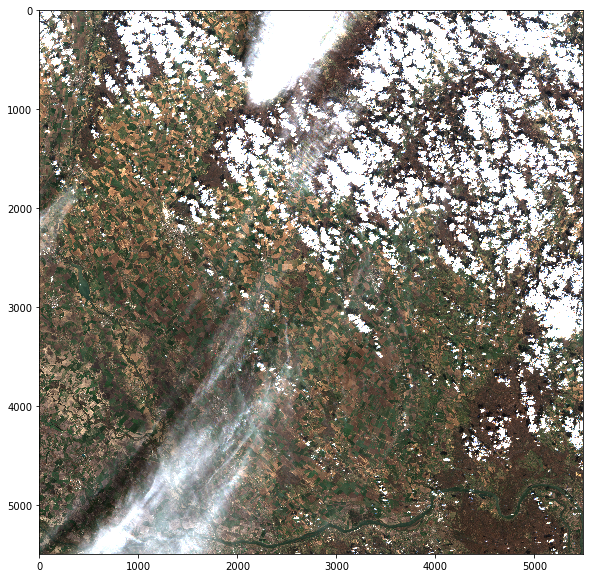

In [128]:
tci_tif = read_tiff(out_tci_file)
plt.figure(figsize=[10, 10])
plt.imshow(tci_tif)

# NDVI bands

In [126]:
nvdi_vrt_file = os.path.join(out_path, 'nvdi.vrt')
nvdi_tif_file = os.path.join(out_path, 'nvdi.tif')
nvdi_files = [x for x in file_dict['20m'] if 'B11' in x or 'B8A' in x]
nvdi_cmd_list = get_commands(nvdi_vrt_file, nvdi_tif_file, nvdi_files, ot='Int16', set_resolution=False)

# subprocess.call(nvdi_cmd_list[0])  # merge to vrt
# subprocess.call(nvdi_cmd_list[1])  # convert to tif

run_command(nvdi_cmd_list[0])  # merge to vrt
run_command(nvdi_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [74]:
ndvi_tif = read_tiff(nvdi_tif_file)
# plt.imshow(ndvi_tif)

(5490, 5490, 2) 1 16011


In [98]:
nvdi_files

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/T33UYP_20180408T095029_B11_20m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/T33UYP_20180408T095029_B8A_20m.jp2']

-0.9995705389735882 0.7596668649613325


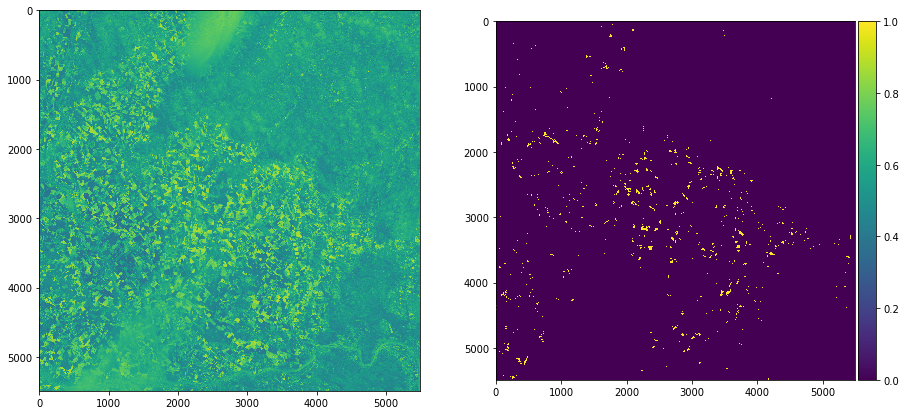

In [124]:
bands = dict(zip(['B8A', 'B11'], [1, 0]))

def calculate_ndvi(image):
    rval = np.divide(image[..., bands['B8A']] - image[..., bands['B11']],
                     image[..., bands['B8A']] + image[..., bands['B11']])
    return np.where(np.isnan(rval), 0., rval)

ndvi = calculate_ndvi(ndvi_tif)
print(ndvi.min(), ndvi.max())
fig, axs = plt.subplots(1, 2, figsize=[15, 10])
axs[0].imshow(ndvi)
img = axs[1].imshow(np.float32(ndvi > 0.5))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax)

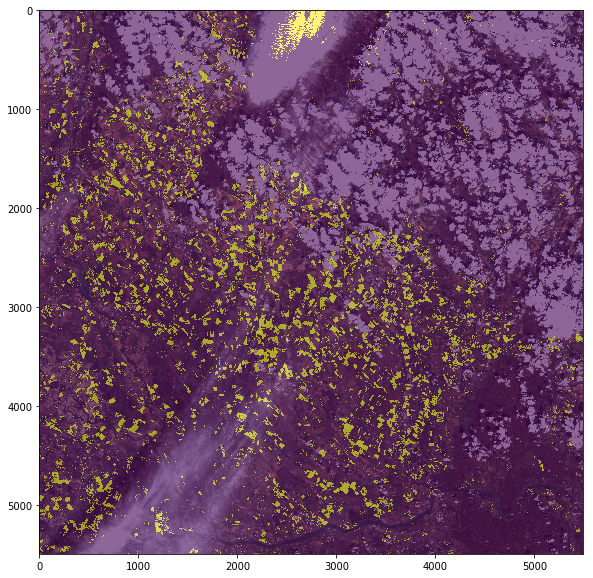

In [119]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.imshow(tci_tif)
ax.imshow(np.float32(ndvi > 0.3), alpha=0.6)

# All bands

In [64]:
all_bands_vrt_file = os.path.join(out_path, "all_bands.vrt")
all_bands_tif_file = os.path.join(out_path, "all_bands.tif")
all_bands_files = [x for x in file_dict['20m'] if 'B0' in x or 'B8A' in x]

In [69]:
all_bands_cmd_list = get_commands(all_bands_vrt_file, all_bands_tif_file, all_bands_files,
                                  ot='Int16', set_resolution=False)
run_command(all_bands_cmd_list[0])  # merge to vrt
run_command(all_bands_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [75]:
all_bands = read_tiff(all_bands_tif_file)

(5490, 5490, 7) 1 18890


In [113]:
[x for x in file_dict['10m'] if 'B0' in x or 'B8A' in x]

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B02_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B03_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B04_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B08_10m.jp2']

In [112]:
[x for x in file_dict['60m'] if 'B0' in x or 'B8A' in x]

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B01_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B02_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B03_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B04_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B05_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T0

In [96]:
all_bands_files = [x for x in file_dict['10m'] if 'B0' in x or 'B8A' in x]
all_bands_cmd_list = get_commands(all_bands_vrt_file, all_bands_tif_file, all_bands_files,
                                  ot='Int16', set_resolution=True)
run_command(all_bands_cmd_list[0])  # merge to vrt
run_command(all_bands_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [97]:
all_bands = read_tiff(all_bands_tif_file)

(5490, 5490, 9) 1 20700
